# Quantization aware (QKeras) DeepSet Permutation Invariant NN for B Jet tagging using jet constituents from HLS data implemented by Patrick ( from paper https://arxiv.org/abs/1703.06114 )

##   Original code from: https://github.com/bb511/know_dist

## Author: Andre Sznajder

 

In [1]:
#!fusermount -u drive
#! pip install einops
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'

In [2]:
import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
print(tf.config.list_physical_devices())
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

# To disable GPU use
tf.config.set_visible_devices([], 'GPU')


TensorFlow 2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of available GPUs : 1


## Load train and test JetID datasets as numpy arrays

In [3]:
import numpy as np
import h5py
import os
import awkward as ak

#Data PATH
PATH = './part1_outputs_btagging/'

nconstit = 16

X_train_val = ak.from_parquet(PATH+"X_train_scaled.parquet")
X_test = ak.from_parquet(PATH+"X_test_scaled.parquet")
Y_train_val = ak.from_parquet(PATH+"y_train_scaled.parquet")
Y_test = ak.from_parquet(PATH+"y_test_scaled.parquet")

X_train_val = ak.to_numpy(X_train_val)
X_test = ak.to_numpy(X_test)
Y_train_val = ak.to_numpy(Y_train_val)
Y_test = ak.to_numpy(Y_test)

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", Y_train_val.shape)
print("Loaded Y_test      ----> shape:", Y_test.shape)

nfeat = X_train_val.shape[-1]

print(Y_test)

Loaded X_train_val ----> shape: (160000, 16, 6)
Loaded X_test      ----> shape: (40000, 16, 6)
Loaded Y_train_val ----> shape: (160000, 1)
Loaded Y_test      ----> shape: (40000, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


## Define DeepSet Permutation Invariant Model

In [4]:
# baseline keras model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, Input, Activation, Dense, Conv1D, Add, RepeatVector
from tensorflow.keras.layers import Flatten, Reshape, GlobalAveragePooling1D, Concatenate, UpSampling1D, AveragePooling1D, MaxPooling1D  
from tensorflow.keras import utils, regularizers
from qkeras import *

import tensorflow.keras.layers as KL



#########################################################################################################
'''
# Silence the info from tensorflow in which it brags that it can run on cpu nicely.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
keras.utils.set_random_seed(123)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

from util.terminal_colors import tcols
from . import util as dsutil

tf.keras.backend.set_floatx("float64")

util.util.device_info()
outdir = util.util.make_output_directory("trained_deepsets", args["outdir"])
util.util.save_hyperparameters_file(args, outdir)

data = Data.shuffled(**args["data_hyperparams"])
'''
#########################################################################################################

# Quantized bits
nbits=8
integ=0

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

qact = 'quantized_relu({},0)'.format(nbits)

# Print
print("Training with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)
print("Quantization of integer part=",integ)

#############################################################################


nnodes_phi = 32
nnodes_rho = 32
activ      = "relu"
#activ      = "elu"
REGL = regularizers.L1(0.0001) 


# Number of target classes
nclasses = len(Y_train_val[0]) 

# Instantiate Tensorflow input tensors in Batch mode 
inp = Input(shape=(nconstit,nfeat), name="inp")   # Conv1D input format


# Input point features BatchNormalization 
#h = BatchNormalization(name='BatchNorm')(inp)
#h = QBatchNormalization(name='batchnorm', beta_quantizer=qbits, gamma_quantizer=qbits)(inp)
h=inp
# Phi MLP ( permutation equivariant layers )
h = QDense(nnodes_phi, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_phi1', kernel_regularizer=REGL, bias_regularizer=REGL )(h)
h = QActivation(qact,name='qrelu_phi1')(h)
h = QDense(nnodes_phi, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_phi2', kernel_regularizer=REGL, bias_regularizer=REGL )(h)
h = QActivation(qact,name='qrelu_phi2')(h)
h = QDense(nnodes_phi, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_phi3', kernel_regularizer=REGL, bias_regularizer=REGL )(h)
phi_out = QActivation(qact,name='qrelu_phi3')(h)
 
# Linear activation to change HLS bitwidth to fix overflow in AveragePooling
#h = QActivation(activation='quantized_bits(14,5)', name = 'linear_activation')(h)

# Agregate features (taking mean) over set elements  
mean = GlobalAveragePooling1D(name='avgpool')(phi_out)      # return mean of features over elements
#mean = tf.reduce_mean(phi_out, axis=1)                     # return mean of features over elements


# Rho MLP
h = QDense(nnodes_rho, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_rho1', kernel_regularizer=REGL, bias_regularizer=REGL )(mean)
h = QActivation(qact,name='qrelu_rho1')(h)
h = QDense(nnodes_rho, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_rho2', kernel_regularizer=REGL, bias_regularizer=REGL )(h)
h = QActivation(qact,name='qrelu_rho2')(h)
h = QDense(nclasses, kernel_quantizer=qbits, bias_quantizer=qbits,name='qdense_rho3', kernel_regularizer=REGL, bias_regularizer=REGL )(h)
#out = Activation('softmax',name='softmax')(h)
out = Activation('sigmoid',name='sigmoid')(h)

# Build the model
model = Model(inputs=inp, outputs=out)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0005,decay=1e-6)
optim = Adam(learning_rate=0.0003)
#optim = Adam()

# compile the model
#model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()




Training with max # of contituents =  16
Number of node features =  6
Quantization with nbits= 8
Quantization of integer part= 0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 16, 6)]           0         
                                                                 
 qdense_phi1 (QDense)        (None, 16, 32)            224       
                                                                 
 qrelu_phi1 (QActivation)    (None, 16, 32)            0         
                                                                 
 qdense_phi2 (QDense)        (None, 16, 32)            1056      
                                                                 
 qrelu_phi2 (QActivation)    (None, 16, 32)            0         
                                                                 
 qdense_phi3 (QDense)        (None, 16, 32)            1056     

## Run training

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Figure o merit to monitor during training
merit = 'val_loss'
#merit = 'val_accuracy'

# early stopping callback
es = EarlyStopping(monitor=merit, patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor=merit, factor=0.2, patience=10)

# Set NN and output name
arch = 'QDeepSets_PermutationInv'
fname = arch+'_nconst_'+str(nconstit)+'_nbits_'+str(nbits)
print('Model name : ',fname)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('model_'+fname+'.h5', monitor=merit, 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq='epoch',period=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
history = model.fit( X_train_val, Y_train_val, 
                    epochs=60, 
                    batch_size=128, 
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[es,ls,chkp])
 

Model name :  QDeepSets_PermutationInv_nconst_16_nbits_8
Epoch 1/60


2023-12-15 06:10:12.023279: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


875/875 [==============================] - 4s 4ms/step - loss: 0.6326 - accuracy: 0.7339 - val_loss: 0.6049 - val_accuracy: 0.7434 - lr: 3.0000e-04
Epoch 2/60
875/875 [==============================] - 3s 4ms/step - loss: 0.5971 - accuracy: 0.7457 - val_loss: 0.5898 - val_accuracy: 0.7482 - lr: 3.0000e-04
Epoch 3/60
875/875 [==============================] - 3s 3ms/step - loss: 0.5862 - accuracy: 0.7484 - val_loss: 0.5813 - val_accuracy: 0.7497 - lr: 3.0000e-04
Epoch 4/60
875/875 [==============================] - 3s 3ms/step - loss: 0.5776 - accuracy: 0.7509 - val_loss: 0.5739 - val_accuracy: 0.7498 - lr: 3.0000e-04
Epoch 5/60
875/875 [==============================] - 3s 4ms/step - loss: 0.5703 - accuracy: 0.7535 - val_loss: 0.5677 - val_accuracy: 0.7516 - lr: 3.0000e-04
Epoch 6/60
875/875 [==============================] - 3s 4ms/step - loss: 0.5647 - accuracy: 0.7550 - val_loss: 0.5648 - val_accuracy: 0.7522 - lr: 3.0000e-04
Epoch 7/60
875/875 [==============================] - 3s 

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve using the best saved model

(40000, 16, 6)
(40000, 1)


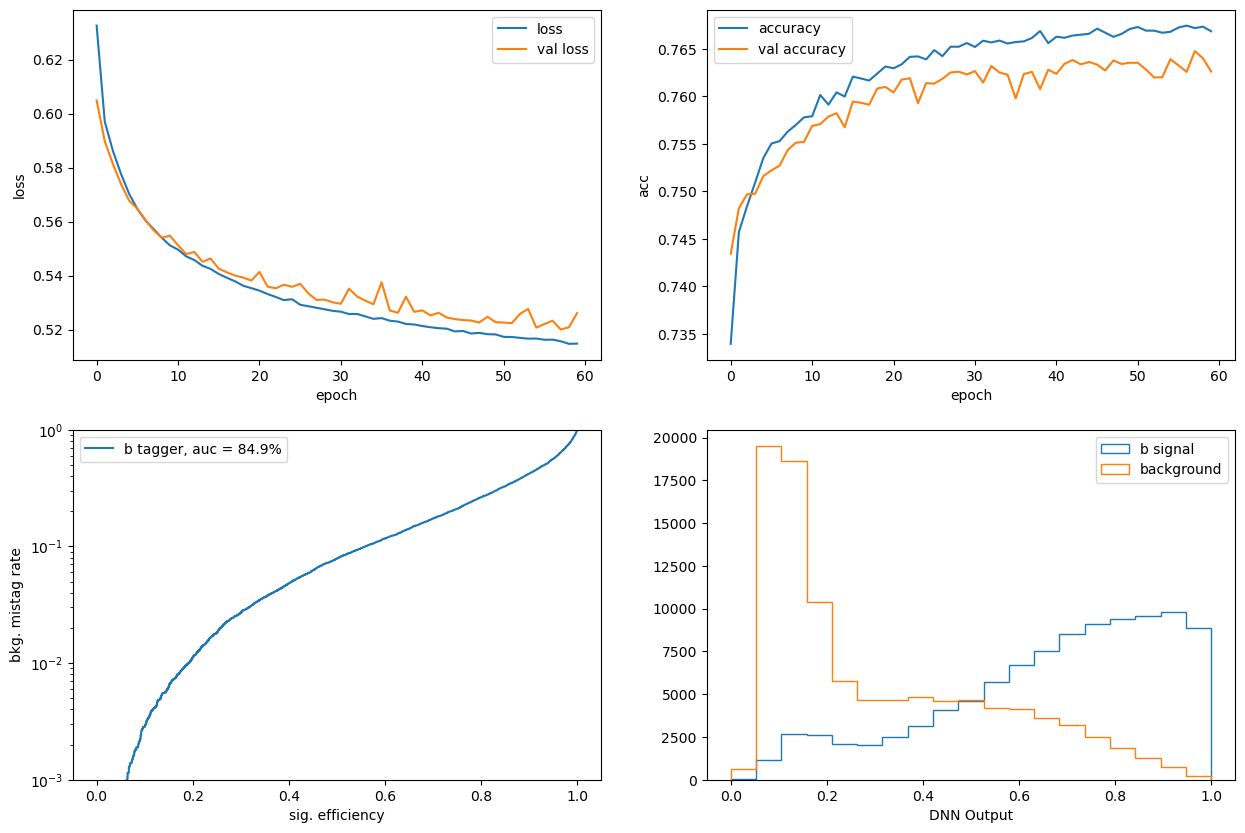

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Load the best saved model
model = tf.keras.models.load_model('model_'+fname+'.h5', custom_objects={"QDense": QDense, "QActivation": QActivation, "quantized_bits": quantized_bits})

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['val_accuracy'], label='val accuracy')
#ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
#ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

'''
# Plot the ROC curves
#labels = ['gluon', 'quark', 'W', 'Z', 'top']
labels = ['b']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}
'''


ax = plt.subplot(2, 2, 3)
Y_predict = model.predict(X_test)


'''
# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
'''

fpr, tpr, tresholds = roc_curve(Y_test, Y_predict)
auc1 = auc(fpr, tpr)
ax.plot(tpr,fpr,label='%s tagger, auc = %.1f%%'%("b",auc1*100.))

ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='upper left')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))


'''
# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')
'''

print(X_test.shape)
print(Y_predict.shape)

# Plot DNN output 
# Selects events with NNoutput > cut

x_sig = ak.from_parquet(PATH+"x_sig_scaled.parquet")
x_bkg = ak.from_parquet(PATH+"x_bkg_scaled.parquet")

x_sig = ak.to_numpy(x_sig)
x_bkg = ak.to_numpy(x_bkg)

y_sig_predict = model.predict(x_sig)
y_bkg_predict = model.predict(x_bkg)


ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
histo = ax.hist(y_sig_predict, bins=X, label='b signal' ,histtype='step')
histo = ax.hist(y_bkg_predict, bins=X, label='background' ,histtype='step')
#ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='upper right')


# Display plots
fig = plt.gcf()
plt.show()